In [1]:
import sys
sys.path.append('../libs/')
sys.path.append('../')
import morphen as mp
import libs as mlibs
import numpy as np
# from libs import *
import matplotlib.pyplot as plt
import os
import re
import glob
import tqdm
import lmfit
import scipy


from astropy.io import fits
from astropy.wcs import WCS


def reload_libs():
    import libs as mlibs
    from importlib import reload
    reload(mlibs)
    import morphen as mp
    reload(mp)


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

## Spectral Indeces

In [2]:
def prepare_data(root_paths,prefix_images):
    """
    Helper function to organise a list of sub-band images.
    """
    MFS_images = []
    MFS_residuals = []
    imagelist = []
    residuallist = []
    freqlist = []
    for i in range(len(root_paths)):
        root_path_i = root_paths[i]
        prefix_images_i = prefix_images[i]
        imagelist_i = mlibs.glob.glob(root_path_i+prefix_images_i)
        imagelist_i, residuallist_i, freqs_i = mlibs.sort_list_by_freq(imagelist_i)
        MFS_images.append(imagelist_i[0].replace('0000-image','MFS-image'))
        MFS_residuals.append(residuallist_i[0].replace('0000-residual','MFS-residual'))

        imagelist.extend(imagelist_i)
        residuallist.extend(residuallist_i)
        freqlist.extend(freqs_i)
        
    freqlist_MFS = mlibs.getfreqs(MFS_images)


    imagelist_beam,residuallist_beam = \
        mlibs.sort_list_by_beam_size(imagelist=MFS_images,
                                     return_df = False)
#     ax=mlibs.eimshow(imagelist_beam[0],crop=True,add_beam=True)
    return(np.asarray(MFS_images),
           np.asarray(MFS_residuals),
           np.asarray(imagelist),
           np.asarray(residuallist),
           freqlist_MFS,
           np.asarray(freqlist))



First, lets provide the path and prefix of the images.

The function `prepare_data` will return the MFS image alongside the sub-band images and residuals. The list will be sorted with increasing frequency.

In [3]:
root_path = ["/media/sagauga/starbyte/dave_images/"
            ]
prefix_images = ["CY2204_0955+6940*-????-image-pb.fits",
                ]
MFS_images,MFS_residuals,imagelist,residuallist,freqlist_MFS,freqlist = prepare_data(root_path,prefix_images)



0 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0000-image-pb.fits
1 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0001-image-pb.fits
2 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0002-image-pb.fits
3 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0003-image-pb.fits
4 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0004-image-pb.fits
5 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0005-image-pb.fits
6 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0006-image-pb.fits
7 >> CY2204_0955+6940_avg_loop_32_FR_Gef-0007-image-pb.fits


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 82.88it/s]

0 >> CY2204_0955+6940_avg_loop_32_FR_Gef-MFS-image-pb.fits


In [4]:
freqlist/1e9

array([4.8128, 4.9408, 5.0688, 5.1968, 6.0096, 6.1376, 6.2656, 6.3936])

## Selecting the reference image (the MFS image)
We may use the MFS-image for source detection purposes. 


In [5]:
# With morphen, we can store a image using the class mp.read_data. Note that the associated residual image must be provided.
idx = 0# since we have just one image
input_data=mp.read_data(filename=MFS_images[idx],
                        residualname=MFS_residuals[idx])

++>> Image File: CY2204_0955+6940_avg_loop_32_FR_Gef-MFS-image-pb.fits
++>> Residual File: CY2204_0955+6940_avg_loop_32_FR_Gef-MFS-residual-pb.fits
-->> No PSF File was provided.


## Plot the entire map
For reference, we use the MFS image(s) for visualisation and also for source detection, as it contains the best $SNR$.

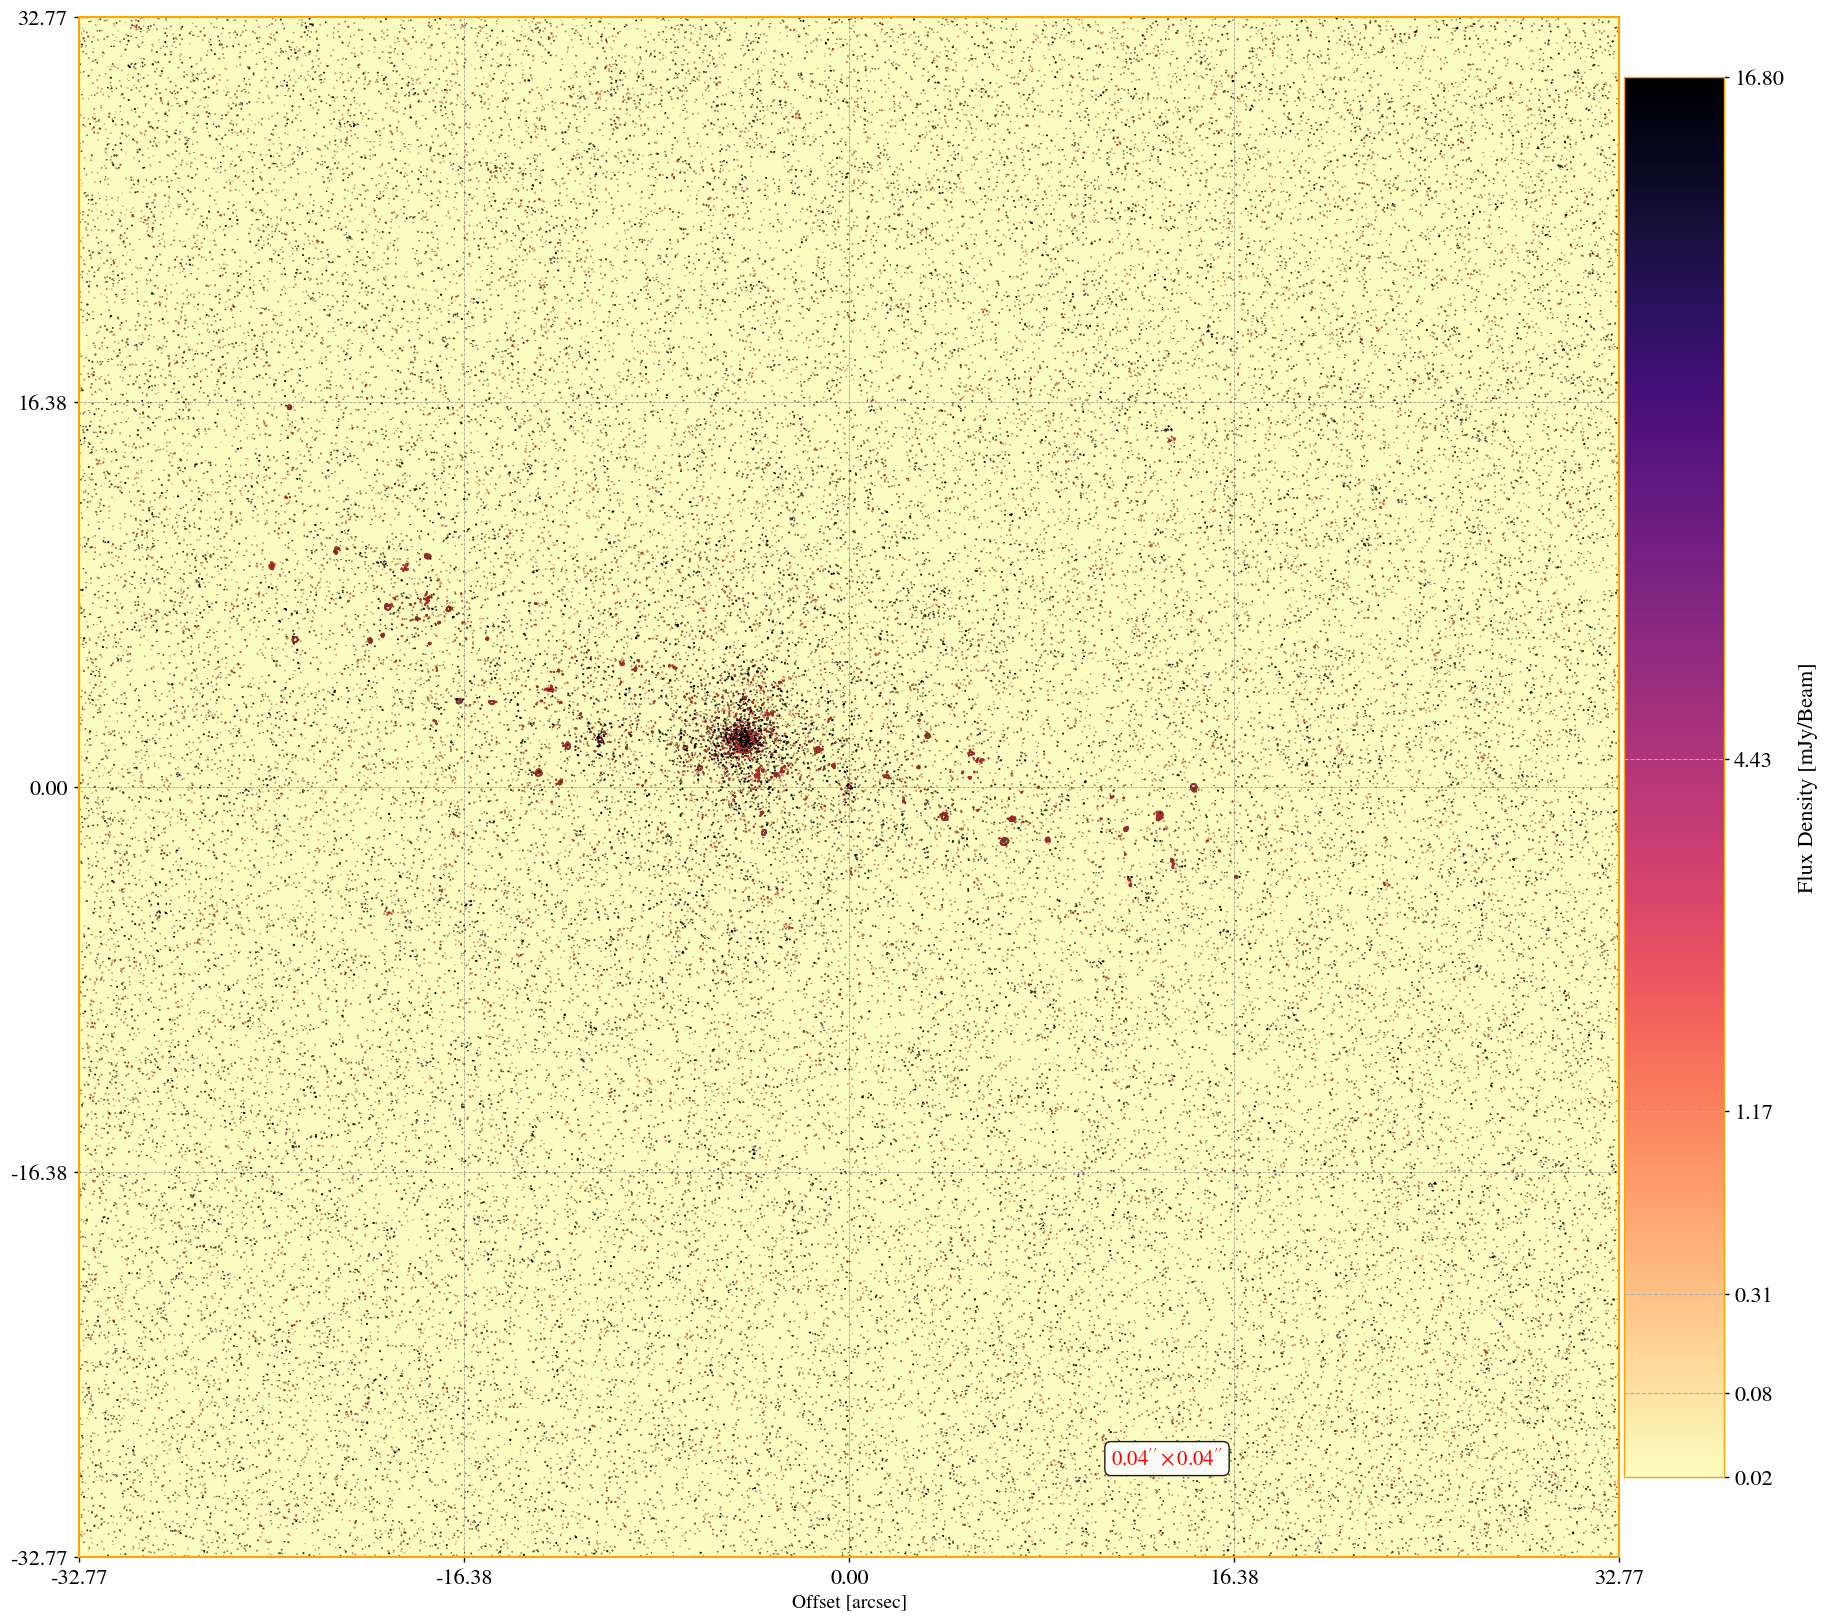

In [6]:

ax=mlibs.eimshow(input_data.filename,
#                  crop=False,
#                  box_size=int(700/2),
                 plot_colorbar = True,
                 add_beam=True,figsize=(20, 20))

## Make a catalog
We can now create a catalog of sources from the image

In [7]:
#rename the images/residuals for processing.  
# We now are also goint to make use of the sub-band images.
imagelist_run = imagelist.copy()
residuallist_run = residuallist.copy()
frequencies = freqlist.copy()


In [ ]:
"""
To generate our mask, we use the MFS image, which contains improved SNR. 

Below, I am using a thresold of 10 x rms[sigma_mad]. 
If mask dilation_size = None, half of beam size will be used as the size of the dilation. 
You may open the image in a new tab. 
"""
_,mask = mlibs.mask_dilation(input_data.filename,
                             rms=input_data.rms_res,
                             show_figure=True,
                             PLOT=True,
                             iterations=4,
                             dilation_size=None,
                             fig_size_factor=3,
                             sigma=10)

 ==>  Dilation size is 2 [px]


In [ ]:
f"{input_data.rms_res*1e6:.2f} muJy/beam"

In [ ]:
"""
For the detection, we multiply the image data with our mask. This will make things easier and avoid the 
detection of garbage. 

"""

beam_area_in_px = mlibs.beam_area2(input_data.filename)
# to avoid detection of strutures smaller than the beam, we set npixels as the number of pixels within the beam.
npixels = int(beam_area_in_px*1.0)
cat, segm, segm_deblend = mlibs.make_catalog(image=input_data.image_data_2D*mask,
                                       threshold=6.0 * input_data.rms_res,
                                       deblend=False,
                                    #    kernel_size=7,#this was deprecated in the new version of photutils/petrofit
                                    #    fwhm=3, #this was deprecated in the new version of photutils/petrofit
                                       npixels=npixels,
                                       nlevels = 64,
                                       plot=False, 
                                       vmax=0.1*input_data.image_data_2D.max(),
                                       vmin=0.1 * input_data.rms_res)

indices = mlibs.order_cat(cat, key='segment_flux', reverse=True)
max_flux = np.nanmax(cat.kron_flux/beam_area_in_px)
min_flux = np.nanmin(cat.kron_flux/beam_area_in_px)
print(f"Number of sources detected = {len(indices)}")
print(f"With fluxes ranging from {max_flux*1000:.2f} mJy to {min_flux*1000:.2f} mJy")
masks_deblended = []
for k in range(len(indices)):
#     print(k)
    masks_deblended.append(segm == segm.labels[indices[k]])
#         idx = sorted_idx_list[0]  # index 0 is largest



In [ ]:
# some information (from photutils/petrofit) are stored in `cat`

In [ ]:
cat??

In [ ]:
cat.centroid[0]

In [ ]:
# Now, we can plot each detected source 
for i in range(len(indices)):
#     centre = mlibs.nd.maximum_position(masks_deblended[i]*input_data.image_data_2D) #use this if want the centre to be the position of the peak
    centre = int(cat.centroid[indices[i]][1]),int(cat.centroid[indices[i]][0]) # use this if want the centre to be the centre of mass
    ax=mlibs.eimshow(input_data.image_data_2D,center=centre,
                     rms=input_data.rms_res,plot_colorbar=True,vmax_factor=0.9,
#                      add_beam=True,
#                      save_name = f"{os.path.dirname(input_data.filename)}/MFS_map_source_{i}",
                     crop=True,box_size=60)
    plt.show()
    plt.close()

In [ ]:
"""
To speed up things, lets load all sub-band images at once. 
WARNING: High memory usage (~10 GB in this case). 
"""
sub_band_img_cube = []
sub_band_res_cube = []
for kk in tqdm.tqdm(range(len(imagelist_run))):
    sub_band_img_cube.append(mlibs.ctn(imagelist_run[kk]))
    sub_band_res_cube.append(mlibs.ctn(residuallist_run[kk]))

## Step-by-step analysis

### Loading a single source; use source_id

In [ ]:
source_id = 1
source_centre = (int(cat[indices[source_id]].centroid[1]),
                 int(cat[indices[source_id]].centroid[0]))
print(f"Source centre {source_centre}")

source_img_data_MFS = mlibs.do_cutout_2D(image_data=input_data.image_data_2D,
                                         box_size=(50,50),center=source_centre)
source_res_data_MFS = mlibs.do_cutout_2D(image_data=input_data.residual_data_2D,
                                         box_size=(50,50),center=source_centre)

source_img_data_cube = []
source_res_data_cube = []
for kk in tqdm.tqdm(range(len(imagelist_run))):
    sub_band_image = imagelist_run[kk]
    sub_band_res = residuallist_run[kk]
    
#     source_img_data = mlibs.do_cutout_2D(image_data=mlibs.ctn(sub_band_image),
#                                          box_size=(50,50),center=source_centre)
#     source_res_data = mlibs.do_cutout_2D(image_data=mlibs.ctn(sub_band_res),
#                                          box_size=(50,50),center=source_centre)
    source_img_data = mlibs.do_cutout_2D(image_data=sub_band_img_cube[kk],
                                         box_size=(50,50),center=source_centre)
    source_res_data = mlibs.do_cutout_2D(image_data=sub_band_res_cube[kk],
                                         box_size=(50,50),center=source_centre)
    source_img_data_cube.append(source_img_data)
    source_res_data_cube.append(source_res_data)
    
source_img_data_cube = np.dstack(source_img_data_cube)
source_res_data_cube = np.dstack(source_res_data_cube)
source_ref_mask = mlibs.do_cutout_2D(image_data=mask,
                                     box_size=(50,50),center=source_centre)

In [ ]:
"""
The mask below, `,mask_source` is obtained from the MFS image, and it will be used as a reference to mask all sub-band images during the 
computation of the alpha map. 
2 key arguments are: 
    - iterations (default is 2)
    - sigma (default is 6)
For sources with enough SNR,`iterations=2` and `sigma=6` is optimal. 
For strong sources, with artefacts, `iterations = 2` and `sigma = 10` or `sigma=15` is more appropriate. 
For very poor SNR, `iterations=3` and `sigma=4` can work. 

Sigma where is the value to be multiplied by the rms value.

"""
sigma = 6
iterations = 2
rms=mlibs.mad_std(source_res_data_MFS)

_,mask_source = mlibs.mask_dilation(source_img_data_MFS,rms=rms,
                                  cell_size=mlibs.get_cell_size(input_data.filename),
                                  dilation_size=mlibs.get_dilation_size(input_data.filename),
                                  iterations=iterations,sigma=sigma,
                                  PLOT=True,show_figure=True
                                 )

### Spectral index map

In [ ]:
alphaimage, alphaimage_error,conv_cube,masked_cube_res,masked_cube\
    = mlibs.specidx_map(imagelist=source_img_data_cube,
                        residuallist=source_res_data_cube,
                        freqs=freqlist,
#                   ref_image_mask = imagelist_run[0],
                  mask=mask_source,
                  dilation_size=None,
                  verbose=1,
                  sigma_global_mask=6)

In [ ]:
mlibs.plot_alpha_map(alphaimage=alphaimage,
                     alphaimage_error = alphaimage_error,
                     plot_title=r'$\alpha$ map',cmap='magma_r',
                     vmax=0.0,vmin=-2.0,
                     crop=True,box_size=(40,40),
#                      plot_alpha_error_points=True,
                     radio_map=source_img_data_MFS,
                     rms=mlibs.mad_std(source_res_data_MFS),
                     frequencies=frequencies)

In [ ]:
source_img_data_MFS.shape

In [ ]:
# centre = mlibs.nd.maximum_position(source_img_data_MFS)[::-1] # use this to re-compute the centre according to the peak of flux 
centre = int(source_img_data_MFS.shape[0]/2),int(source_img_data_MFS.shape[0]/2) #use this to keep the original positin of the centroid
cell_size = mlibs.get_cell_size(imagelist_run[0])
r_end = int(mlibs.area_to_radii(np.sum(mask_source)))
radius_im, intensity_im = mlibs.get_profile(source_img_data_MFS, center=centre)
radius_alpha, intensity_alpha = mlibs.get_profile(alphaimage, center=centre)
radius_alpha_err, intensity_alpha_err = mlibs.get_profile(alphaimage_error, center=centre)


In [ ]:
plt.plot(radius_im[0:r_end]*cell_size, 
         abs(1000*intensity_im[0:r_end]), 
#          label='Image Data'
        )
# plt.semilogy()
plt.xlabel(r'Projected Radius $R$ [arcsec]')
plt.ylabel(r'Intensity Profile $I(R)$ [mJy/beam]')

In [ ]:

plt.plot(radius_alpha[0:r_end]*cell_size, intensity_alpha[0:r_end],
         marker='.',linestyle='-.',
#          label=r'$\alpha$ Profile'
        )

plt.fill_between(radius_alpha[0:r_end]*cell_size, 
                 intensity_alpha[0:r_end] - intensity_alpha_err[0:r_end], 
                 intensity_alpha[0:r_end] + intensity_alpha_err[0:r_end], 
                 color='gray', alpha=0.2,
#                  label='Error Margin'
                )
plt.xlim(0,r_end*cell_size)
plt.xlabel(r'Projected Radius $R$ [arcsec]')
plt.ylabel(r'$\alpha(R)$')
# plt.legend()
plt.ylim(-3.0,0.5)
# plt.title("in Band VLA")
# plt.semilogy()

### Image morphology

We can use the function `mlibs.compute_image_properties` to measure basic properties from each image.


In [ ]:
"""
By default, `mlibs.compute_image_properties` will return the following quantities:
levels, fluxes, agrow, omask, mask, results
What is useful for us now is juts the `results` quantity, which is a dictionary containing
multiple image measures. 

First, lets compute information of the source using the MFS image.
"""
img_props = mlibs.compute_image_properties(img=input_data.filename,
                               residual=input_data.residualname,
                               data_res=source_res_data_MFS,
                               rms=input_data.rms_res,
#                              mask=mask_source,
                               data_2D=source_img_data_MFS)[-1]

In [ ]:
print(f"Total flux density = \
{img_props['total_flux_mask']*1000:.2f}+/-\
{img_props['flux_error_res_3']*1000:.2f} mJy")

In [ ]:
cell_size=mlibs.get_cell_size(input_data.filename)
pix_to_pc = mlibs.pixsize_to_pc(z=mlibs.find_z_NED('M82'),
                               cell_size=cell_size)
print(f"Source Half-light Size = \
{img_props['C50radii']:.2f} [px]")
print(f"Source Half-light Size = \
{img_props['C50radii']*cell_size*1000:.2f} [mas]")
print(f"Source Half-light Size = \
{img_props['C50radii']*pix_to_pc:.2f} [pc]")

print('++++++++++++++++++++++')

print(f"Source Total Size = \
{img_props['C95radii']:.2f} [px]")
print(f"Source Total Size = \
{img_props['C95radii']*cell_size*1:.2f} [mas]")
print(f"Source Total Size = \
{img_props['C95radii']*pix_to_pc:.2f} [pc]")

## Computing information of the sub-band images
For that, we need to loop over `source_img_data_cube`

In [ ]:
source_centre

In [ ]:
source_img_data_cube.shape

In [ ]:
source_img_data_cube[:,:,1].max()

In [ ]:
# mlibs.plt.imshow(source_img_data_cube[:,:,1],
#               vmax=source_img_data_cube[:,:,1].max(),
#               vmin=(source_img_data_cube[:,:,1].min())
# #               rms=abs(source_img_data_cube[:,:,1].min())
#                 )

In [ ]:
cell_size = mlibs.get_cell_size(input_data.filename)
dilation_size = mlibs.get_dilation_size(input_data.filename)


sub_band_properties_all = []
FREQLIST = []
for i_sub_band in range(source_img_data_cube.shape[2]):
    try:
        _,sub_band_mask_source = mlibs.mask_dilation(source_img_data_cube[:,:,i_sub_band],
                                      cell_size=cell_size,
                                      dilation_size=dilation_size,
                                      iterations=iterations,sigma=sigma,PLOT=False,show_figure=False
                                     )

        img_props_subband = mlibs.compute_image_properties(img=input_data.filename,
                                                           residual=input_data.residualname,
                                                           data_res=source_res_data_cube[:,:,i_sub_band],
                                                           sigma_mask=sigma, 
#                                                            rms=None, results=None, bkg_to_sub=None,
#                                                            rms=mlibs.mad_std(source_res_data_cube[:,:,i_sub_band]), #we re-compute the rms for the particular sub-band image
                                                           mask=sub_band_mask_source,
                                                           last_level=1.5,
                                                           data_2D=source_img_data_cube[:,:,i_sub_band])[-1]
        sub_band_properties_all.append(img_props_subband)
        FREQLIST.append(freqlist[i_sub_band])
    except:
        print(f"Error on measuring subband image {i_sub_band} @ {freqlist[i_sub_band]/1e9} GHz")
FREQLIST = np.asarray(FREQLIST)

In [ ]:
sub_band_properties_all

In [ ]:
"""
Now, we can convert the sub-band properties into a dataframe.
"""

In [ ]:
df_subband_props = mlibs.pd.DataFrame(sub_band_properties_all)

In [ ]:
df_subband_props['total_flux_mask']

In [ ]:
plt.errorbar(x=FREQLIST/1e9,
             y=df_subband_props['total_flux_mask']*1000,
             yerr=abs(df_subband_props['flux_error_res_3'])*1000,
             fmt='o',label='Data', color='k', ecolor='gray',alpha=0.5)
plt.xlabel('Freq [GHz]')
plt.ylabel(r'Source $S_{\nu}$ [mJy]')

In [ ]:
mini_1,result_1 = mlibs.do_fit_spec_RC_linear(freqlist,
                                              np.asarray(df_subband_props['total_flux_mask']*1000),
                                              np.asarray(abs(df_subband_props['flux_error_res_3'])*1000),
                                              plot_errors_shade=True,
                                              do_mcmc_fit=True,
#                                               basename_save=os.path.dirname(MFS_images[0])+'/subband_images_',
#                                               save_name_append='eM_C_VLA_X_Ku_K_total',
                                              title_text = r'Total Emission (Power Law)'
                                             )


                                                          ..___|**_
                                                  .|||||||||*+@+*__*++.
                                              _||||.           .*+;].,#_
                                         _|||*_                _    .@@@#@.
                                   _|||||_               .@##@#| _||_
       Morphen                |****_                   .@.,/\..@_.
                             #///#+++*|    .       .@@@;#.,.\@.
                              .||__|**|||||*||*+@#];_.  ;,;_
 Geferson Lucatelli                            +\*_.__|**#
                                              |..      .]]
                                               ;@       @.*.
                                                #|       _;]];|.
                                                 ]_          _+;]@.
                                                 _/_             |]\|    .  _
                                              ...._@* __ .

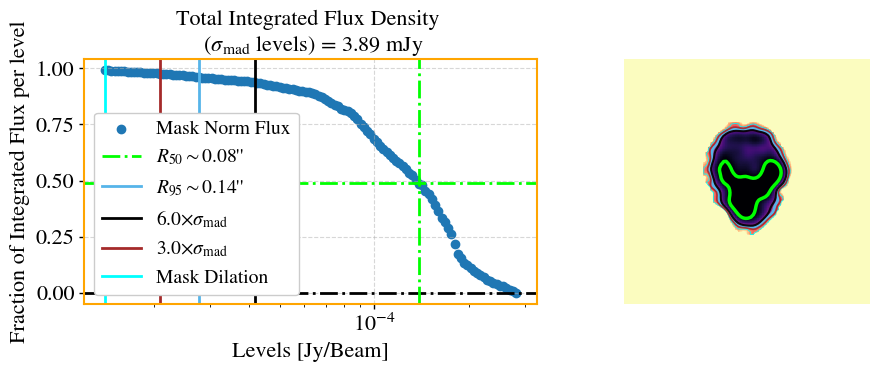

({'peak_of_flux': 0.0002817061613313854,
  'total_flux': 0.004296560921465945,
  'inner_flux': 0.003764737705648787,
  'low_flux': 0.0002855343455496699,
  'mid_flux': 0.0,
  'uncertain_flux': 0.00024628887026748795,
  'inner_flux_f': 0.8762211858418838,
  'low_flux_f': 0.06645648712278665,
  'mid_flux_f': 0.0,
  'uncertain_flux_f': 0.05732232703532959,
  'number_of_beams': 35.831221464790616,
  'n_beams_inner': 33.254197655007644,
  'n_beams_mid': 0.0,
  'n_beams_low': 5.118745923541517,
  'n_beams_uncertain': 11.578956296011155,
  'total_flux_nomask': 0.004296529990473136,
  'total_flux_mask': 0.003925125005989102,
  'max_residual': 9.8635691756499e-06,
  'min_residual': -1.986652750929352e-05,
  'flux_residual': -6.391085494001557e-05,
  'flux_error_res': 0.00019173256482004673,
  'flux_error_res_2': 0.00026909444793898966,
  'flux_error_res_3': 0.0002064005178475104,
  'mad_std_residual': 6.683620971624715e-06,
  'rms_residual': 6.737039433506295e-06,
  'total_flux_levels': 0.00388

In [30]:
# reload_libs()
# mlibs.measures(imagename=input_data.filename,
#                residualname=input_data.residualname,
#                z = mlibs.find_z_NED('M82'),
#                rms = input_data.rms_res,
#                data_2D = source_img_data_MFS,
#                data_res = source_res_data_MFS,
#                mask = mask_source
#               )